In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding

In [ ]:
from tensorflow import keras

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [ ]:
def build_model(batch_size, seq_len, unique_chars):
    model = Sequential()
    model.add(Embedding(unique_chars, 256, batch_input_shape=(batch_size, seq_len)))
  
    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))
    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))
    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))
    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Dense(unique_chars))) 
    model.add(Activation('softmax'))
    return model

In [ ]:
def model_to_predict(unique_chars):
    model = Sequential()
    model.add(Embedding(unique_chars, 256, batch_input_shape=(1, 1)))

    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))
    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))
    model.add(LSTM(128, return_sequences=True, stateful=True))
    model.add(Dropout(0.25))
    model.add(LSTM(128, return_sequences=False, stateful=True))
    model.add(Dropout(0.25))

    model.add(Dense(unique_chars))
    model.add(Activation('softmax'))
    return model

In [ ]:
def make_dictionary_from_all_input(text):
  unique_characters = sorted(set(text))

  dict_of_char_to_index = {char: index for index, char in enumerate(unique_characters)}
  dict_of_index_to_char = {index: char for index, char in enumerate(unique_characters)}


  no_of_unique_chars = len(unique_characters)

  return dict_of_char_to_index,dict_of_index_to_char,no_of_unique_chars

In [ ]:
def convert_the_input_char_to_integers(text,dict_of_char_to_index):
  input_as_integers = np.asarray([dict_of_char_to_index[c] for c in text], dtype=np.int32)
  return input_as_integers

In [ ]:
def make_different_batches(input_as_integers,batchsize,length_of_sequence,no_of_unique_chars):

  no_of_batches = input_as_integers.shape[0]//batchsize     #Total number of characters/number of char in a batch
  rows_per_batch = batchsize//length_of_sequence
  

  X = np.zeros((no_of_batches,rows_per_batch, length_of_sequence))      
  Y = np.zeros((no_of_batches,rows_per_batch, length_of_sequence,no_of_unique_chars))

  print(X.shape)
  print(Y.shape)
  current_batch = 0
  current_row = 0
  i = 0

  while(i<(no_of_batches*batchsize)):
    current_char_list = input_as_integers[i:i+length_of_sequence]           #For X
    shifted_char_list = input_as_integers[i+1:i+length_of_sequence+1]       #For Y

    X[current_batch,current_row,:] = current_char_list

    hot_encoder_per_batch = np.zeros((length_of_sequence,no_of_unique_chars))

    #Making one hot encoded of the list of next characters
    for index, char in enumerate(shifted_char_list) :
      hot_encoder_per_batch[index][char] = 1

    Y[current_batch,current_row,:,:] = hot_encoder_per_batch

    current_batch = (current_batch+1)%no_of_batches

    if current_batch == 0:
      current_row+=1

    i+=length_of_sequence

  return X,Y  

In [ ]:
def train_the_model(X, Y, epochs, save_model_duration, unique_char, rows_per_batch,sequence):  

  model = build_model(rows_per_batch, sequence, unique_char)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  losses = []
  accurracies = []
  epoches = []
  for epoch in range(epochs):
    epoches.append(epoch+1)

    _loss = []
    _acc = []
    for b in range(len(X)):
      x = X[b]
      y = Y[b]
      loss, acc = model.train_on_batch(x, y)
      _loss.append(loss)
      _acc.append(acc)
    
    losses.append(np.average(_loss))
    accurracies.append(np.average(_acc))
    print('Epoch {}: Loss = {}, Accuracy = {}'.format(epoch + 1, _loss[-1], _acc[-1]))

    if (epoch + 1) % save_model_duration == 0:
      model.save_weights(os.path.join(".", 'model.{}.h5'.format(epoch+1)))


  return epoches, losses, accurracies

In [ ]:
def predict_the_outputs(model,no_of_chars_to_predict,dict_of_char_to_index,dict_of_index_to_char,starting_char):

  # print(starting_char)
  predicted_chars = [dict_of_char_to_index[c] for c in starting_char]
  # print(predicted_chars)
  

  for i in range(no_of_chars_to_predict):
      batch = np.zeros((1, 1))
      if len(predicted_chars) == 0:
          batch[0, 0] = np.random.randint(len(dict_of_char_to_index))
          
      else:
        batch[0, 0] = predicted_chars[-1]
          
          
      y_pred = model.predict_on_batch(batch).ravel()
      next_char = np.random.choice(range(len(dict_of_char_to_index)), p=y_pred)
      predicted_chars.append(next_char)

  return predicted_chars

def predict(path_of_model,dict_of_char_to_index,dict_of_index_to_char,no_of_chars_to_predict,starting_char,name_of_model):

  model = model_to_predict(len(dict_of_char_to_index))
  model.load_weights(os.path.join(path_of_model, name_of_model))

  output_list = predict_the_outputs(model,no_of_chars_to_predict,dict_of_char_to_index,dict_of_index_to_char,starting_char)

  music = ""

  # print(output_list)
  for i in output_list:
    music+=str(dict_of_index_to_char[i])

  return music



In [ ]:
f=open("processed_data.txt","w")

count=0
with open("all_song_abc.txt","r") as file:
  for line in file:
    if line[0] not in ["\n","X","T","%","M","K","P","S","L","V"]:
      f.write(line)


with open("processed_data.txt", 'r') as file:
      text = file.read()


SEQUENCE_LENGTH_PER_BATCH = 64
NO_OF_ROWS_PER_BATCH = 16

dict_of_char_to_index,dict_of_index_to_char,no_of_unique_chars = make_dictionary_from_all_input(text)
T = convert_the_input_char_to_integers(text,dict_of_char_to_index)
X,Y = make_different_batches(T,NO_OF_ROWS_PER_BATCH*SEQUENCE_LENGTH_PER_BATCH,SEQUENCE_LENGTH_PER_BATCH,no_of_unique_chars)

(342, 16, 64)
(342, 16, 64, 69)


In [ ]:
epoches, losses, accurracies = train_the_model(X, Y, epochs = 50, 
                                               save_model_duration = 10, 
                                               unique_char = no_of_unique_chars,
                                               rows_per_batch = NO_OF_ROWS_PER_BATCH,
                                               sequence = SEQUENCE_LENGTH_PER_BATCH
                                               )

Epoch 1: Loss = 2.6833407878875732, Accuracy = 0.26953125
Epoch 2: Loss = 1.7613141536712646, Accuracy = 0.478515625
Epoch 3: Loss = 1.609399437904358, Accuracy = 0.5078125
Epoch 4: Loss = 1.5156384706497192, Accuracy = 0.5234375
Epoch 5: Loss = 1.4396405220031738, Accuracy = 0.5234375
Epoch 6: Loss = 1.415630578994751, Accuracy = 0.5361328125
Epoch 7: Loss = 1.3848072290420532, Accuracy = 0.541015625
Epoch 8: Loss = 1.3636335134506226, Accuracy = 0.556640625
Epoch 9: Loss = 1.310457706451416, Accuracy = 0.552734375
Epoch 10: Loss = 1.2912136316299438, Accuracy = 0.5673828125
Epoch 11: Loss = 1.2740525007247925, Accuracy = 0.57421875
Epoch 12: Loss = 1.2558050155639648, Accuracy = 0.5712890625
Epoch 13: Loss = 1.2241382598876953, Accuracy = 0.5986328125
Epoch 14: Loss = 1.2401148080825806, Accuracy = 0.5869140625
Epoch 15: Loss = 1.2058533430099487, Accuracy = 0.5947265625
Epoch 16: Loss = 1.1883341073989868, Accuracy = 0.59375
Epoch 17: Loss = 1.1598846912384033, Accuracy = 0.61230468

In [ ]:
import matplotlib.pyplot as plt   
def visualizeLosses(epochs, losses, accuracies):
    
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title("Loss vs Epoch - LSTM") 
    plt.plot(epochs, losses, label = "Loss")
    # plt.plot(epochs, accuracies, label = "Accuracy")
    # plt.legend(loc='upper right')
    plt.show()
    print()

    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title("Accuracy vs Epoch - LSTM") 
    # plt.plot(epochs, losses, label = "Loss")
    plt.plot(epochs, accuracies, label = "Accuracy")
    # plt.legend(loc='upper right')
    plt.show()
    print()


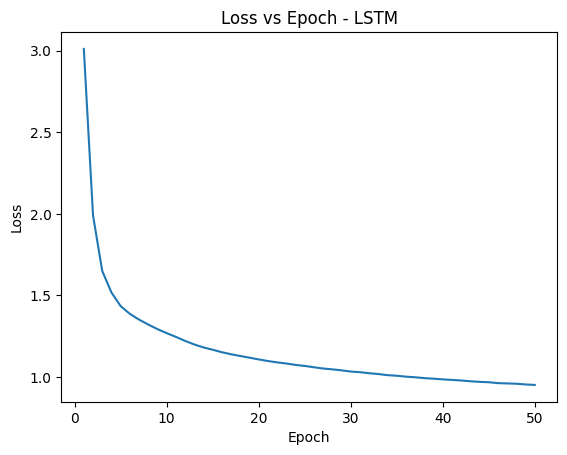

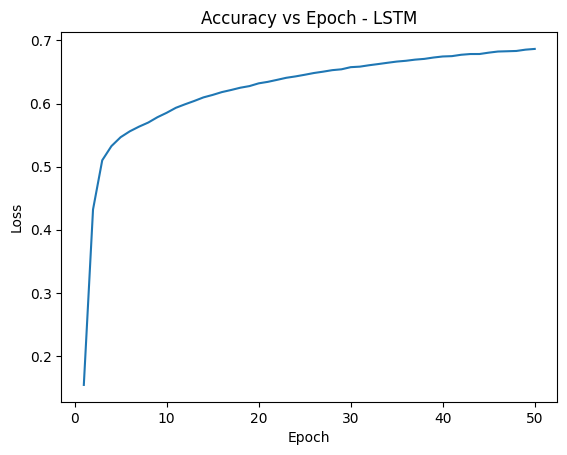

In [ ]:
visualizeLosses(epoches, losses, accurracies)

In [ ]:
generated_sequence = predict(".",dict_of_char_to_index,dict_of_index_to_char,100,"E","model.50.h5")
print(generated_sequence)

E3fa7|
"D7"dcd BAG|"G"deB dee|"D"f3 ffd|"D7"f2e gfc|"G"d2G Gd||
f|cBe Bcd|BAd dcB|AAD A2G|
Gdc AFG|AF


In [ ]:
generated_sequence = predict(".",dict_of_char_to_index,dict_of_index_to_char,200,"C","model.50.h5")
print(generated_sequence)

Ce3c3|"C"cce g2e|"G"d2B GGB|"Am"c3 A2:|
e|"D"f2e d2f|"Bm"e2f -"E7""c"d2B|"E7"BGE "E7"EFE|"A"E2E ABc|"D"d2B "G"G2B|
"Em"cBc c2A|B3 -B3|"D"d3 d2e|"G"g2B "A7"BAE|"D"DED DFD|
"D"DFA B2A|"G"G2B B2A|"C"c3 -B
